In [1]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import itertools
import networkx as nx
from imdb_helper_functions import *
from selenium.webdriver.support.select import Select
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### get_actors_by_movie_soup
* This function takes a beautifulsoup soup object (`cast_page_soup`) of a page for the cast & crew for the current film.
* The function should return a list of all actors that played in the movie. An actor should be defined by such a pair: `(name_of_actor, url_to_actor_page)`. So, the output of the function is expected to be the list of such pairs.
* The function should be able to take an optional argument `num_of_actors`. This argument allows us to limit the output. If we set the argument equal to, say, 10, then the function should return first 10 actors listed on the cast page, and no more than that. If we set the argument equal to `None`, then the function should return all the actors.

In [ ]:
def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):
    # taking the table with onlt the casts
    casts = cast_page_soup.find_all('table', class_='cast_list')
    global actors_all
    actors_list = []
    # including the limit in case we need only some actors
    if num_of_actors_limit == None:
        limit = len(casts[0])
    else:
        limit = num_of_actors_limit
    # looking through the casts table
    for soup in casts:
        #taking only the tr tag with odd and even classes
        for soupp in soup.find_all('tr', class_ = re.compile(r'(odd|even)')):
            #there are 4 td tags in he tr tag. The desired one is the second td tag
            #each actors name and the link are in the tag 'a'
            
            actor = soupp.find_all('td')[1].find_all('a')[0].text[1:-1].strip('r')
            link = 'https://www.imdb.com' + soupp.find_all('td')[1].find_all('a')[0]['href']
            
            #finding them and adding to the list of actors
            actors_list.append((actor,link))
            actors_all[actor] = link
            # reducing the limit
            limit -= 1
            if limit == 0:
                return actors_list
                break
    return actors_list



### get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit)

* This functions takes a beautifulsoup soup object (`actor_page_soup`) of a page for the current actor.
* The function should return a list of all movies that the actor played in. A movie should be defined by such a pair: `(name_of_movie, url_to_movie_page)`. So, the output of the function is expected to be the list of such pairs.
* The function should be able to take an optional argument `num_of_movies_limit`. This argument allows us to limit the output. If we set the argument equal to, say, 10, then the function should return 10 latest movies that the actor played in, and no more than that. If we set the argument equal to None, then the function should return all the movies.
* The function should return only those movies, that have already been released.
* Sometimes actors could be producers, or even directors, or something else. The function should return only those movies, where the actor did an acting job. So, we should omit all the movies, where the actor has not actually played a role.
* The function should return only full feature movies. So, it should omit other types of videos, which are marked on imdb like that: TV Series, Short, Video Game, Video short, Video, TV Movie, TV Mini-Series, TV Series short and TV Special.


In [ ]:
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    #movies are in the div tag with the class 'actor-ttnumber' or 'actress-ttnumber'
    #used the re.compile to catch the actor and actress classes in div tags
    performance = actor_page_soup.find_all('div', attrs={'id' : re.compile(r'\Aact[a-z-]{2,5}tt[\d]*')})
    global movies_all
    movies_list = []
    # including the limit in case we need only some movies
    if num_of_movies_limit == None:
        limit = len(performance)
    else:
        limit = num_of_movies_limit
    for perf in performance:
        # used the re.compile to catch the not the full feature movies
        if len(re.findall(re.compile(r'(Music Video|\(Short\b\)|TV Series'+\
                                        '|\(Video Game\)|Video short'+\
                                        '|\(Video\)|TV Movie|TV Mini Series'+\
                                        '|TV Series short|TV Special|Mini-Series|Documentary short|'+\
                                        'Podcast Series|Podcast Episode)'),perf.text)) == 0:
            for movie in perf.find_all('a'):
                # add try except to omit the non-released movies
                try:
                    if 'in_production' in movie['class']:
                        movies_list.pop()
                        limit += 1
                        break
                except:
                    #add if statement to omit empty links or links with some symbols
                    if 'title' in movie['href']:
                        movies_list.append((movie.text, 'https://www.imdb.com' + movie['href']))
                        movies_all[movie.text] = 'https://www.imdb.com' + movie['href']
                        #reducing the limit
                        limit -= 1
                        if limit == 0:
                            return movies_list
                
    return movies_list


### get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None)

* This function has two mandatory arguments: `actor_start_url`, `actor_end_url` - urls to imdb pages of actors, that we want to measure *movie distance* between
* This function should return an integer, a *movie distance* between the given actors
* The function may also get optional arguments `num_of_actors` and `num_of_movies`, but we will talk about them later.

In [ ]:
def get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None):
    global actors_info
    global movies_info
    
    if actor_start_url not in actors_info:
        actors_info.update(updating_by_actors(actor_start_url ,num_of_movies_limit))
    if actor_end_url not in actors_info:
        actors_info.update(updating_by_actors(actor_end_url, num_of_movies_limit))

    dist = 1
    movies = set(actors_info[actor_start_url])
    end_movies = set(actors_info[actor_end_url])
    if movies & end_movies:
        return dist

    seen = movies.copy()
    
    while True:
        dist += 1
        if dist > 3:
            return 'inf'
        next_step = set()
        for movie in movies:
            
            if movie not in movies_info:
                movies_info.update(updating_by_movies(movie,num_of_actors_limit))
                
            for actor in movies_info[movie]:
                if actor not in actors_info:
                    actors_info.update(updating_by_actors(actor,num_of_movies_limit))
                
                next_step.update(actors_info[actor])
            
            
        movies = next_step - seen 

        # Has actorB been in any of those movies?
        if movies & end_movies:
            return dist

        # Update the set of seen movies
        seen.update(movies)




### get_movie_descriptions_by_actor_soup(actor_page_soup):

* This function takes a beautifulsoup soup object (`actor_page_soup`) of a page for the the current actor.
* The function should return a list strings. Each element is a short description of a movie, where the actor played. Every movie has such a description on its page.

In [ ]:
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    global movie_desc
    movies_desc = ''
    actor_movies = get_movies_by_actor_soup(actor_page_soup)
    for movie in actor_movies:
        
        if movie[0] not in movie_desc:
            movie_soup = get_soup(movie[1])
            movie_text = movie_soup.find('span', {'role': 'presentation', 'data-testid':"plot-xs_to_m"}).text
            movie_desc[movie[0]] = movie_text
            movies_desc = ','.join((movies_desc, movie_text)) 
            
        else:
            movies_desc = ','.join((movies_desc, movie_desc[movie[0]]))
            
    return movies_desc

In [3]:
check_list = {'Dwayne Johnson':'https://www.imdb.com/name/nm0425005/', 
              'Chris Hemsworth':'https://www.imdb.com/name/nm1165110/', 
              'Robert Downey Jr.':'https://www.imdb.com/name/nm0000375/',
              'Akshay Kumar':'https://www.imdb.com/name/nm0474774/', 
              'Jackie Chan':'https://www.imdb.com/name/nm0000329/', 
              'Bradley Cooper':'https://www.imdb.com/name/nm0177896/',
              'Adam Sandler':'https://www.imdb.com/name/nm0001191/',
              'Scarlett Johansson':'https://www.imdb.com/name/nm0424060/',
              'Sofia Vergara':'https://www.imdb.com/name/nm0005527/',
              'Chris Evans':'https://www.imdb.com/name/nm0262635/'}

In [4]:
combinations = list(itertools.combinations(check_list.keys(), 2))

In [23]:
comb_results = []
comb = 1
for i in combinations:
    print(comb, i[0], i[1])
    distance = get_movie_distance(check_list[i[0]],check_list[i[1]], 5, 5)
    comb_results.append([i[0], i[1],distance])
    comb+=1

1 Dwayne Johnson Chris Hemsworth
2 Dwayne Johnson Robert Downey Jr.
3 Dwayne Johnson Akshay Kumar
4 Dwayne Johnson Jackie Chan
5 Dwayne Johnson Bradley Cooper
6 Dwayne Johnson Adam Sandler
7 Dwayne Johnson Scarlett Johansson
8 Dwayne Johnson Sofia Vergara
9 Dwayne Johnson Chris Evans
10 Chris Hemsworth Robert Downey Jr.
11 Chris Hemsworth Akshay Kumar
12 Chris Hemsworth Jackie Chan
13 Chris Hemsworth Bradley Cooper
14 Chris Hemsworth Adam Sandler
15 Chris Hemsworth Scarlett Johansson
16 Chris Hemsworth Sofia Vergara
17 Chris Hemsworth Chris Evans
18 Robert Downey Jr. Akshay Kumar
19 Robert Downey Jr. Jackie Chan
20 Robert Downey Jr. Bradley Cooper
21 Robert Downey Jr. Adam Sandler
22 Robert Downey Jr. Scarlett Johansson
23 Robert Downey Jr. Sofia Vergara
24 Robert Downey Jr. Chris Evans
25 Akshay Kumar Jackie Chan
26 Akshay Kumar Bradley Cooper
27 Akshay Kumar Adam Sandler
28 Akshay Kumar Scarlett Johansson
29 Akshay Kumar Sofia Vergara
30 Akshay Kumar Chris Evans
31 Jackie Chan Bradle

In [27]:
np.savetxt("pairwise movie distances.csv", 
           comb_results,
           delimiter =", ", 
           fmt ='% s')

# Visualising data

## coloring:
dist == 1, red color <br>
dist == 2, green color <br>
dist == 3, blue color<br> 
dist == inf, yellow color<br>

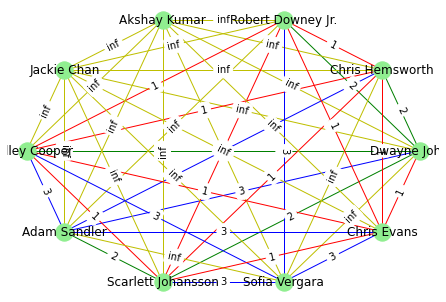

In [13]:
G_all = nx.Graph()
for res in comb_results:
    if res[1] == 1:
        G_all.add_edge(res[0][0], res[0][1], color='r', weight=1)
    elif res[1] == 2:
        G_all.add_edge(res[0][0], res[0][1], color='g', weight=2)
    elif res[1] == 3:
        G_all.add_edge(res[0][0], res[0][1], color='b', weight=3)
    else:
        G_all.add_edge(res[0][0], res[0][1], color='y', weight='inf')

colors = nx.get_edge_attributes(G_all,'color').values()

pos = nx.circular_layout(G_all)
nx.draw(G_all, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')

edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G_all.edges(data=True)])

labels = nx.draw_networkx_edge_labels(G_all, pos, edge_labels=edge_labels)



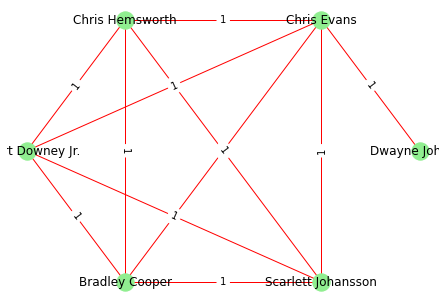

In [14]:
G_1 = nx.Graph()
for res in comb_results:
    if res[1] == 1:
        G_1.add_edge(res[0][0], res[0][1], color='r', weight=1)
    
colors = nx.get_edge_attributes(G_1,'color').values()

pos = nx.circular_layout(G_1)
nx.draw(G_1, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')

edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G_1.edges(data=True)])

labels = nx.draw_networkx_edge_labels(G_1, pos, edge_labels=edge_labels)


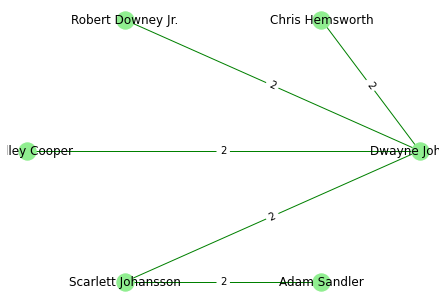

In [15]:
G_2 = nx.Graph()
for res in comb_results:
    if res[1] == 2:
        G_2.add_edge(res[0][0], res[0][1], color='g', weight=2)
    
colors = nx.get_edge_attributes(G_2,'color').values()

pos = nx.circular_layout(G_2)
nx.draw(G_2, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')

edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G_2.edges(data=True)])

labels = nx.draw_networkx_edge_labels(G_2, pos, edge_labels=edge_labels)


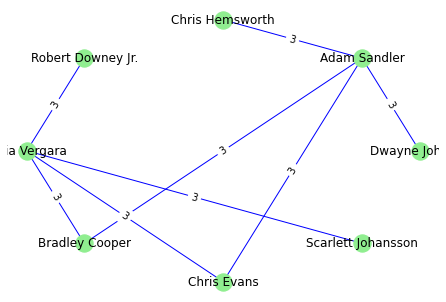

In [16]:
G_3 = nx.Graph()
for res in comb_results:
    if res[1] == 3:
        G_3.add_edge(res[0][0], res[0][1], color='b', weight=3)
    
colors = nx.get_edge_attributes(G_3,'color').values()

pos = nx.circular_layout(G_3)
nx.draw(G_3, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')

edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G_3.edges(data=True)])

labels = nx.draw_networkx_edge_labels(G_3, pos, edge_labels=edge_labels)


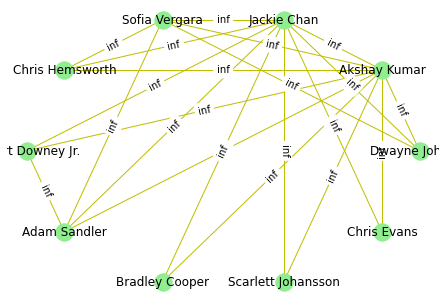

In [17]:
G_inf = nx.Graph()
for res in comb_results:
    if res[1] == 'inf':
        G_inf.add_edge(res[0][0], res[0][1], color='y', weight='inf')
    
colors = nx.get_edge_attributes(G_inf,'color').values()

pos = nx.circular_layout(G_inf)
nx.draw(G_inf, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')

edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G_inf.edges(data=True)])

labels = nx.draw_networkx_edge_labels(G_inf, pos, edge_labels=edge_labels)


In [125]:
for actor, actor_url in check_list.items():
    descriptions = get_movie_descriptions_by_actor_soup(get_soup(actor_url))
    with open(f'{actor} movie descriptions.txt', 'w') as file:
        file.writelines(descriptions)
    print(actor, len(descriptions))

Dwayne Johnson 6612
Chris Hemsworth 4383
Robert Downey Jr. 10956
Akshay Kumar 21011
Jackie Chan 21086
Bradley Cooper 6631
Adam Sandler 8026
Scarlett Johansson 7940
Sofia Vergara 3968
Chris Evans 5964


In [141]:
stopwords = set(STOPWORDS)
stopwords.update({'read','take','must','one','two','three','four','five','six','seven','eight','nine','ten'})

In [142]:
%matplotlib inline

Dwayne Johnson's wordcloud'


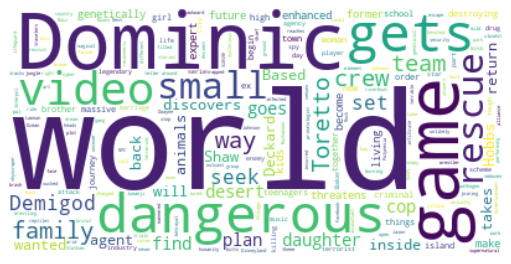

Chris Hemsworth's wordcloud'


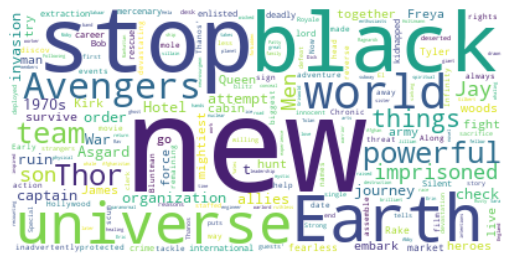

Robert Downey Jr.'s wordcloud'


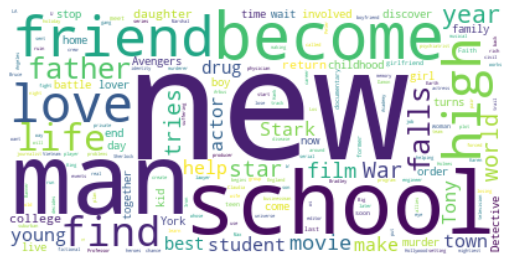

Akshay Kumar's wordcloud'


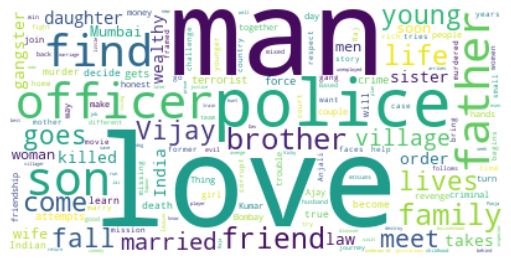

Jackie Chan's wordcloud'


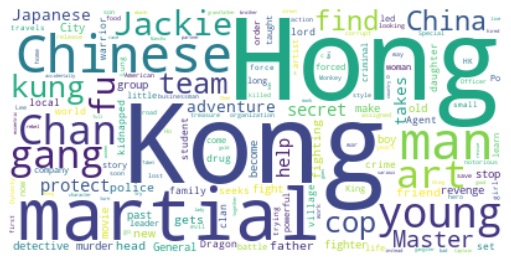

Bradley Cooper's wordcloud'


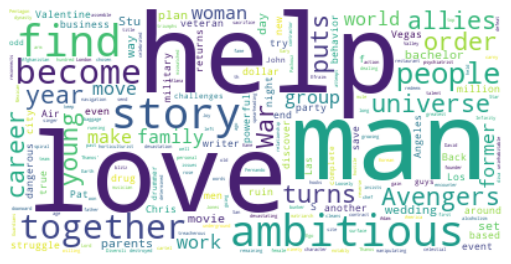

Adam Sandler's wordcloud'


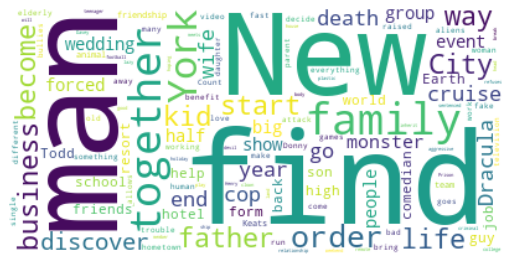

Scarlett Johansson's wordcloud'


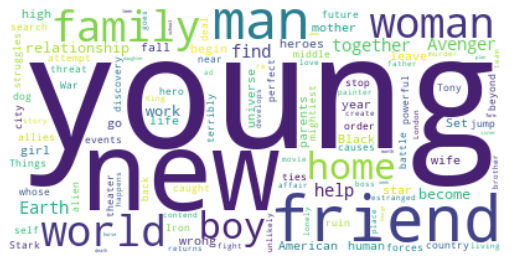

Sofia Vergara's wordcloud'


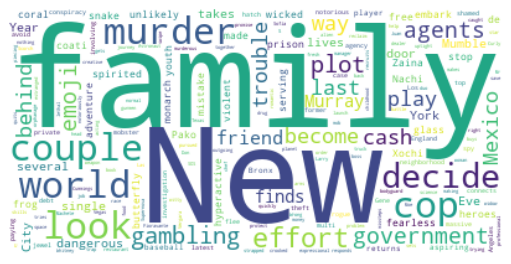

Chris Evans's wordcloud'


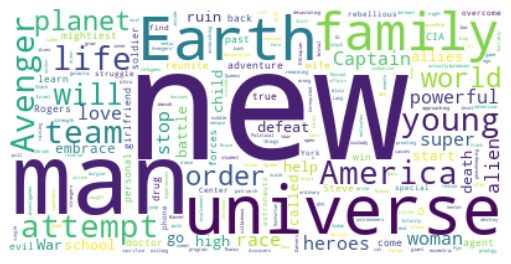

In [143]:
for actor, actor_url in check_list.items():
    with open(f'{actor} movie descriptions.txt') as file:
        description = file.readlines()
    print(f"{actor}'s wordcloud'")
    get_wordcloud(*description)
    